<a href="https://colab.research.google.com/github/martabarbosa1/Project2_Toys-and-Models/blob/main/Project_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wild adventurers

# **Connection**

In [ ]:
!pip install mysql-connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt

import datetime
import mysql.connector 

import seaborn as sns




In [ ]:
# conn = 'mysql://USER:PW@DBHOST/DB'
connection=mysql.connector.connect(user = 'toyscie', password = 'WILD4Rdata!', host = '51.68.18.102', port = '23456', database = 'toys_and_models')
#sql_engine=sql.create_engine(connection)

#**SQL Queries and Vizualization**

##Query Sales:The number of products sold by category and by month, with comparison and rate of change compared to the same month of the previous year

In [ ]:
query_sales= '''WITH productline_quantity AS (
SELECT productline, YEAR(orderDate) order_year, SUM(quantityordered) order_quantity, MONTH(orderDate) order_month
FROM orders
INNER JOIN orderdetails USING (orderNumber)
INNER JOIN products USING (productCode)
GROUP BY productline, order_year, order_month
)
SELECT productline, order_year, order_month, order_quantity,
LAG(order_quantity, 1) OVER (
PARTITION BY productLine, order_month
ORDER BY order_month, order_year) as prev_year_order_quantity, (order_quantity * 100)/lag(order_quantity, 1) OVER (
        PARTITION BY productLine, order_month
        ORDER BY order_month, order_year) as ratechange
FROM
    productline_quantity'''

    

In [ ]:
df_sales = pd.read_sql(query_sales, con=connection)
df_sales.head()

,productline,order_year,order_month,order_quantity,prev_year_order_quantity,ratechange
0,Classic Cars,2021,1,587.0,NaN,NaN
1,Classic Cars,2022,1,1516.0,587.0,258.2624
2,Classic Cars,2021,2,185.0,NaN,NaN
3,Classic Cars,2022,2,1825.0,185.0,986.4865
4,Classic Cars,2021,3,1139.0,NaN,NaN


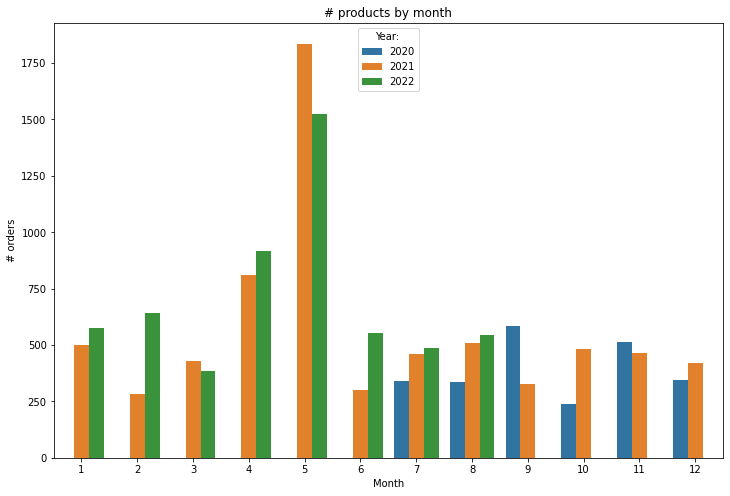

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_sales, x="order_month", y="order_quantity", hue="order_year", ci=None).set(title='# products by month')
axes.set_xlabel("Month")
axes.set_ylabel("# orders")
axes.legend(title="Year: ")

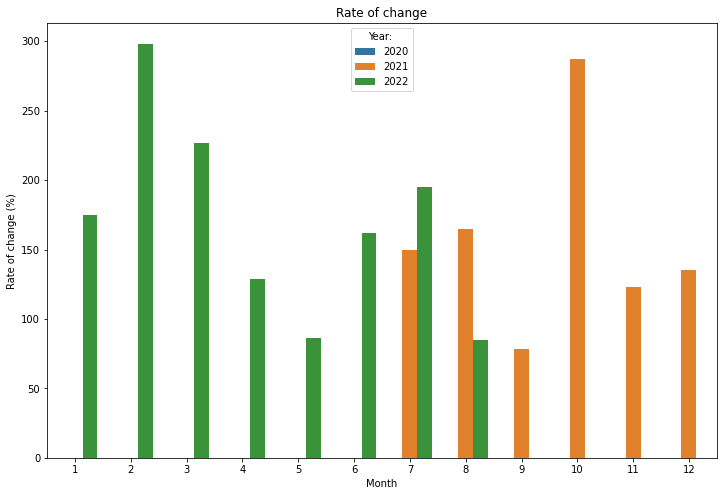

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_sales, x="order_month", y="ratechange", hue="order_year", ci=None).set(title='Rate of change')
axes.set_xlabel("Month")
axes.set_ylabel("Rate of change (%)")
axes.legend(title="Year: ")

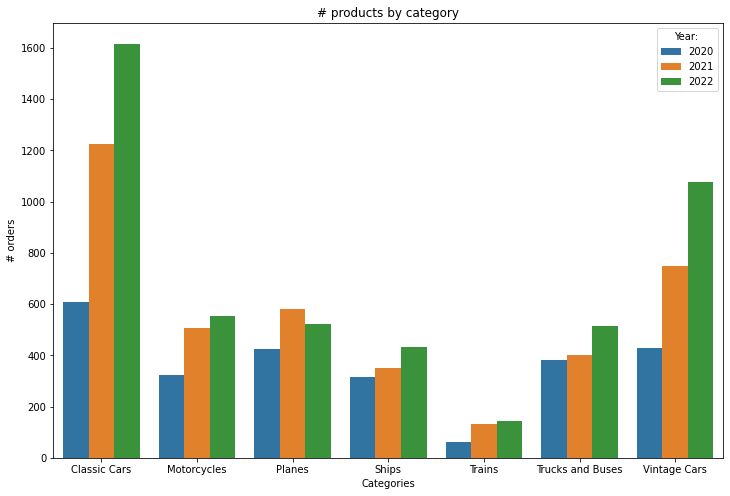

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_sales, x="productline", y="order_quantity", hue="order_year", ci=None).set(title='# products by category')
axes.set_xlabel("Categories")
axes.set_ylabel("# orders")
axes.legend(title="Year: ")

##Query Finances: The turnover of the orders of the last two months by country

In [ ]:
query_finances_to='''select country, sum(priceeach*quantityordered) as turnover
from orders o
join orderdetails od on od.ordernumber=o.ordernumber
join customers c on c.customernumber=o.customernumber
WHERE orderdate >= DATE_FORMAT(CURDATE(), '%Y-%m-01') - INTERVAL 2 MONTH
Group by country
order by turnover'''

In [ ]:
df_finances_to = pd.read_sql(query_finances_to, con=connection)
df_finances_to.head(7)

,country,turnover
0,Belgium,14379.90
1,Japan,33967.73
2,Australia,48516.09
3,France,51358.23
4,Spain,83314.60
5,Finland,116158.76
6,USA,218320.52


Text(0, 0.5, 'Turnover')

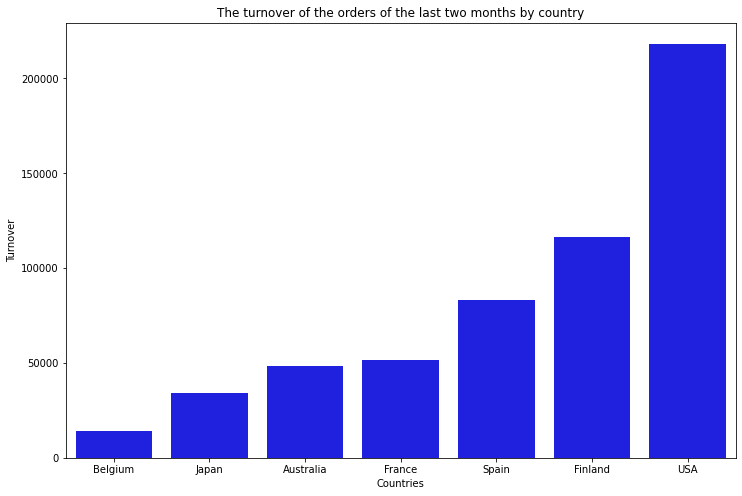

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_finances_to, x="country", y="turnover", color='blue').set(title='The turnover of the orders of the last two months by country')
axes.set_xlabel("Countries")
axes.set_ylabel("Turnover")

##Query Finances: Orders that have not yet been paid

In [ ]:
query_finances_o= '''select o.customernumber, sum(distinct od.quantityordered*od.priceEach) as Total_Amount_Ordered, sum(distinct p.amount) as Total_Amount_Paid, sum(distinct od.quantityordered*od.priceEach) - sum(distinct p.amount) as difference
from orderdetails od
join orders o on o.ordernumber=od.ordernumber
join payments p on p.customernumber=o.customernumber
group by customernumber
having difference > 0'''

In [ ]:
df_finances_o = pd.read_sql(query_finances_o, con=connection)
df_finances_o.head(12)

,customernumber,Total_Amount_Ordered,Total_Amount_Paid,difference
0,124,488672.89,399345.61,89327.28
1,131,149085.15,107639.94,41445.21
2,141,609690.58,483605.66,126084.92
3,144,66694.82,43680.65,23014.17
4,186,95546.46,71943.56,23602.90
5,201,69351.78,61167.18,8184.60
6,219,7918.60,4465.85,3452.75
7,321,118185.21,85559.12,32626.09
8,333,55190.16,33757.85,21432.31
9,357,57989.42,56662.38,1327.04


Text(0, 0.5, 'Difference')

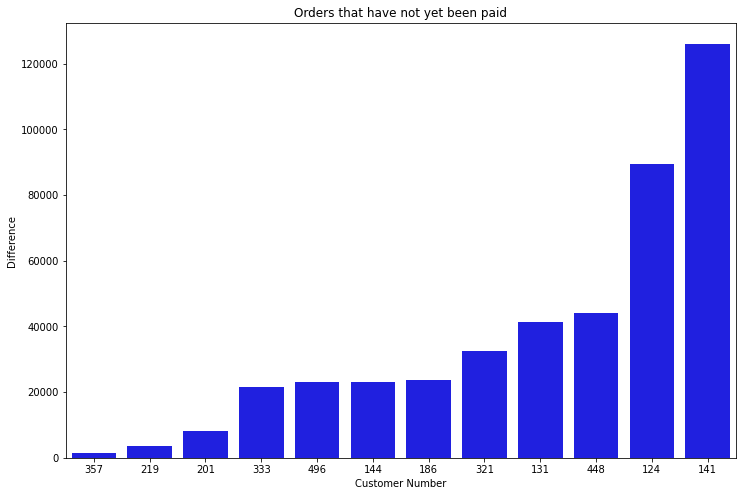

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_finances_o, x="customernumber", y="difference", order=df_finances_o.sort_values('difference').customernumber, color='blue').set(title='Orders that have not yet been paid')
axes.set_xlabel("Customer Number")
axes.set_ylabel("Difference")

## Query Logistics: The stock of the 5 most ordered products

In [ ]:
query_logistics= '''select p.productname, sum(od.quantityordered) as sumOrdered, p.quantityinstock from products p join orderdetails od on p.productcode=od.productCode
group by p.productname
order by sumOrdered desc
limit 5'''

In [ ]:
df_logistics = pd.read_sql(query_logistics, con=connection)
df_logistics.head(5)

,productname,sumOrdered,quantityinstock
0,1992 Ferrari 360 Spider red,1561.0,835
1,1937 Lincoln Berline,960.0,869
2,2001 Ferrari Enzo,950.0,362
3,1913 Ford Model T Speedster,949.0,419
4,1940s Ford truck,947.0,313


Text(0, 0.5, '# quantity in stock')

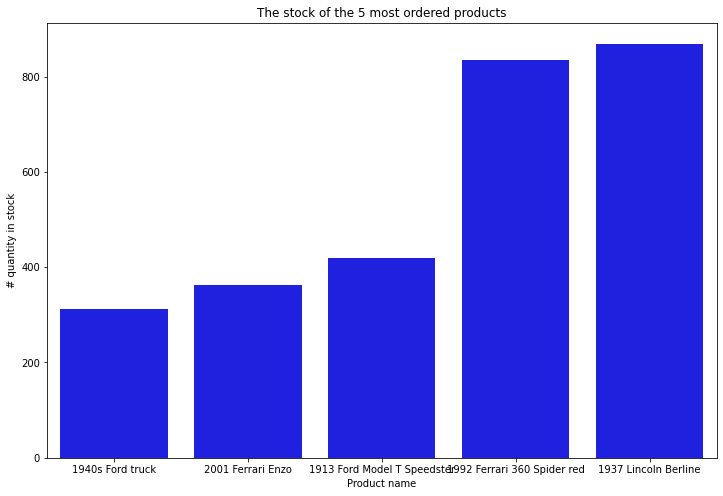

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))
sns.barplot(data=df_logistics, x="productname", y="quantityinstock", order=df_logistics.sort_values('quantityinstock').productname, color='blue').set(title='The stock of the 5 most ordered products')
axes.set_xlabel("Product name")
axes.set_ylabel("# quantity in stock")

##Query Human Resources: Each month, the 2 sellers with the highest turnover

In [ ]:
# query_hr= '''WITH top_sellers AS (select e.employeeNumber, e.firstname, jobTitle, e.lastname, month(o.orderdate) as DateOrd, year(o.orderdate) as YearOrd, sum(od.quantityordered*od.priceeach) as highest_turnover,
# RANK() OVER (PARTITION BY DateOrd ORDER BY highest_turnover DESC) sell_rank from employees e
# join customers c on e.employeeNumber=c.salesRepEmployeeNumber
# join orders o on c.customerNumber=o.customerNumber
# join orderdetails od on o.orderNumber=od.orderNumber
# WHERE jobTitle like 'Sales Rep%' and o.status <> 'Cancelled'
# Group by DateOrd, employeeNumber
# Order by DateOrd, highest_turnover DESC)
# select * from top_sellers
# where sell_rank=1 or sell_rank=2;'''


query_hr= '''WITH top_sellers AS (select e.employeeNumber, e.firstname, jobTitle, e.lastname, DATE_FORMAT(o.orderdate, "%c %Y") as DateOrd, year(o.orderdate) as YearOrd, sum(od.quantityordered*od.priceeach) as highest_turnover,
RANK() OVER (PARTITION BY DateOrd ORDER BY highest_turnover DESC) sell_rank from employees e
join customers c on e.employeeNumber=c.salesRepEmployeeNumber
join orders o on c.customerNumber=o.customerNumber
join orderdetails od on o.orderNumber=od.orderNumber
WHERE jobTitle like 'Sales Rep%' and o.status <> 'Cancelled'
Group by DateOrd, employeeNumber
Order by DateOrd, highest_turnover DESC)
select * from top_sellers
where sell_rank=1 or sell_rank=2;'''


In [ ]:
df_hr = pd.read_sql(query_hr, con=connection)
df_hr.head(53)
df_hr = df_hr[df_hr['YearOrd'] == 2021]
print(df_hr)

    employeeNumber firstname   jobTitle   lastname  DateOrd  YearOrd  \
0             1165    Leslie  Sales Rep   Jennings   1 2021     2021   
1             1612     Peter  Sales Rep      Marsh   1 2021     2021   
6             1370    Gerard  Sales Rep  Hernandez  10 2021     2021   
7             1286  Foon Yue  Sales Rep      Tseng  10 2021     2021   
10            1165    Leslie  Sales Rep   Jennings  11 2021     2021   
11            1612     Peter  Sales Rep      Marsh  11 2021     2021   
14            1612     Peter  Sales Rep      Marsh  12 2021     2021   
15            1323    George  Sales Rep     Vanauf  12 2021     2021   
16            1165    Leslie  Sales Rep   Jennings   2 2021     2021   
17            1166    Leslie  Sales Rep   Thompson   2 2021     2021   
20            1611      Andy  Sales Rep     Fixter   3 2021     2021   
21            1370    Gerard  Sales Rep  Hernandez   3 2021     2021   
24            1165    Leslie  Sales Rep   Jennings   4 2021     

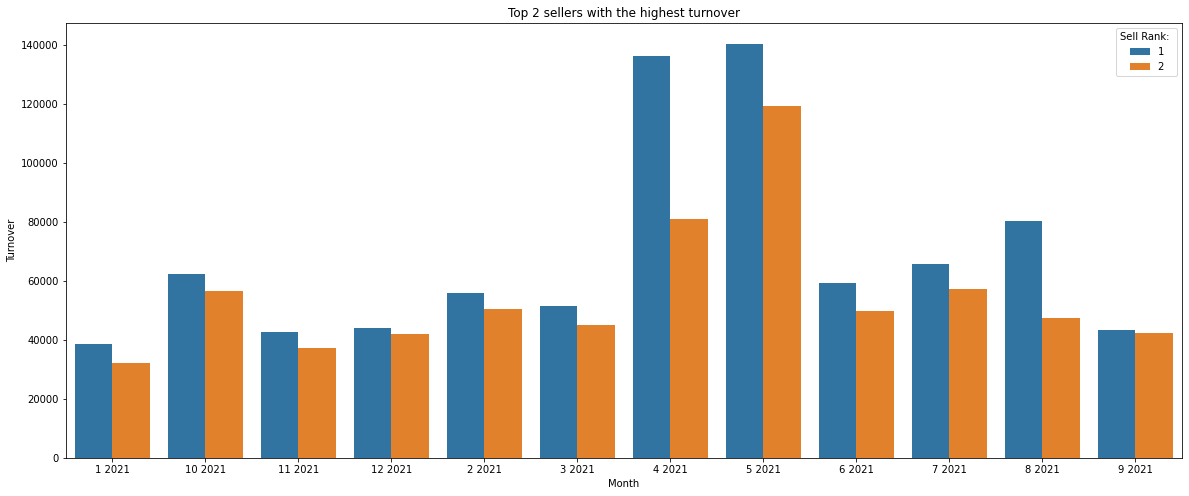

In [ ]:
fig, axes = plt.subplots(figsize=(20,8))
sns.barplot(data=df_hr, x="DateOrd", y="highest_turnover", hue="sell_rank", ci=None).set(title='Top 2 sellers with the highest turnover')
# sns.barplot(data=df_hr, x="DateOrd", y="highest_turnover", hue="firstname", ci=None).set(title='Top 2 sellers with the highest turnover')
axes.set_xlabel("Month")
axes.set_ylabel("Turnover")
axes.legend(title="Sell Rank: ")

In [ ]:
type(df_hr['DateOrd'])

pandas.core.series.Series

In [ ]:
# fig, axes = plt.subplots(figsize=(10,8))
# ax=sns.barplot(data=df_hr, x="DateOrd", y="highest_turnover", hue="sell_rank", ci=None).set(title='Top 2 sellers with the highest turnover')
# # sns.barplot(data=df_hr, x="DateOrd", y="highest_turnover", hue="firstname", ci=None).set(title='Top 2 sellers with the highest turnover')
# axes.set_xlabel("Month")
# axes.set_ylabel("Turnover")
# axes.legend(title="Sell Rank: ")
# for i in ax.containers:
#     ax.bar_label(i,)